In [144]:
import sklearn.datasets as skld
import matplotlib.pyplot as plt
import numpy as np
import torch
import mnist

2.56515205023976e-05
0.005064733013930496


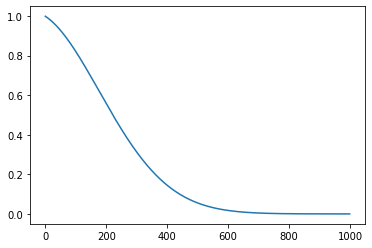

In [145]:
noise_schedule = np.linspace(0.001,0.02,1000)
print((1-noise_schedule).prod())
print((np.sqrt(1-noise_schedule)).prod())
plt.plot((1-noise_schedule).cumprod())

In [146]:
train_images = 2*(mnist.train_images().reshape(-1,28*28)/256 - 0.5)

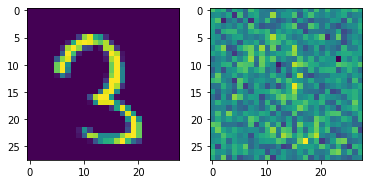

In [207]:
def corrupt(X,t):
    alphas = 1-noise_schedule
    alphabar = alphas[:t].prod()
    mean = np.sqrt(alphabar)*X
    sigma = np.sqrt(1-alphabar)
    X = mean + torch.randn(X.shape)*sigma
    return torch.FloatTensor(X)

def make_data(N):
    idx = np.random.choice(np.arange(train_images.shape[0]), N)
    X0 = train_images[idx]
    return torch.FloatTensor(X0)

X0 = make_data(1000)

X = corrupt(X0,300)

f,axarr = plt.subplots(1,2)
ax = axarr[0]
ax.imshow(X0[0].reshape(28,28))
ax = axarr[1]
ax.imshow(X[0].reshape(28,28))

In [243]:
import torch
make_model = lambda: torch.nn.Sequential(
    torch.nn.Linear(28*28+1,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,28*28),    
)

def make_Xt(X,t):
    tcol = torch.ones((X.shape[0],1))*(t/len(noise_schedule))
    Xt = torch.cat([X,tcol],dim=-1)
    return Xt
    
def train():   
    model = make_model()
    opt = torch.optim.Adam(model.parameters(),3e-4)
    for i in range(5000):
        X0 = make_data(500)
        t = np.random.randint(1,len(noise_schedule))
        X = corrupt(X0,t)
        Xt = make_Xt(X,t)

        pred = model(Xt)
        loss = torch.nn.functional.mse_loss(pred,X0)
        if i % 200 == 0:
            print(i,float(loss))
        loss.backward()
        opt.step()
        opt.zero_grad()
    return model
        
trained_model = train()

0 0.9282254576683044
200 0.27139103412628174
400 0.20755022764205933
600 0.26807889342308044
800 0.24156640470027924
1000 0.13781817257404327
1200 0.27518945932388306
1400 0.15085484087467194
1600 0.2667255699634552
1800 0.20273621380329132
2000 0.11815999448299408
2200 0.09870358556509018
2400 0.2484886348247528
2600 0.28450992703437805
2800 0.11982491612434387
3000 0.26501646637916565
3200 0.26900163292884827
3400 0.17096292972564697
3600 0.08868549019098282
3800 0.07614085078239441
4000 0.26349714398384094
4200 0.27387532591819763
4400 0.08421210199594498
4600 0.16858167946338654
4800 0.110990971326828


In [285]:
def get_mean_sigma(xt,x0,t):
    step = t
    alpha = 1-noise_schedule
    alpha_t = alpha[step]
    alphabar_t = alpha[:step].prod()

    alpha_t1 = alpha[step-1]
    alphabar_t1 = alpha[:step-1].prod()
    f1 = np.sqrt(alpha_t)*(1-alphabar_t1)/(1-alphabar_t)
    f2 = np.sqrt(alphabar_t1)*(1-alpha_t)/(1-alphabar_t)
    xmean = f1*xt + f2*x0
    sigma2 = (1-alphabar_t1)/(1-alphabar_t)*(1-alpha_t)
    return xmean,np.sqrt(sigma2)


def denoise_step(trained_model,X,t):
    Xt = make_Xt(X,t)
    with torch.no_grad():
        X0pred = trained_model(Xt)
    mean,sigma = get_mean_sigma(X,X0pred,t)
    Xt1 = mean + sigma*torch.randn(X.shape)
    return Xt1

def generate(trained_model,N,steps, start = len(noise_schedule), return_trajectory = False, X = None):
    X = X if X is not None else torch.FloatTensor(np.random.normal(0,1,size = (N,28*28)))
    traj = [X]
    for i in range(1,steps):
        t = start - i
        X = denoise_step(trained_model,X,t)
        traj.append(X)
    if return_trajectory:
        return traj
    return X


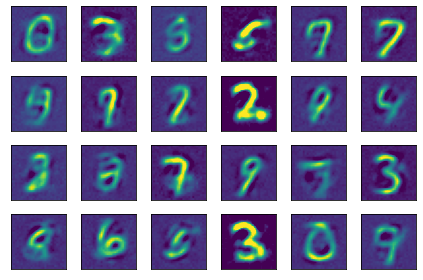

In [257]:
def show(imgs,nrow = 4,ncol = 6):
    fig, axs = plt.subplots(nrow,ncol, squeeze=False)
    for img,ax in zip(imgs,axs.ravel()):
        img = img.detach()
        ax.imshow(np.asarray(img), vmin = -1.5,vmax = 1.5)
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    fig.set_tight_layout(True)
    return fig
    
XG = generate(trained_model,24,999)
grid = XG.reshape(24,28,28)
f = show(grid)

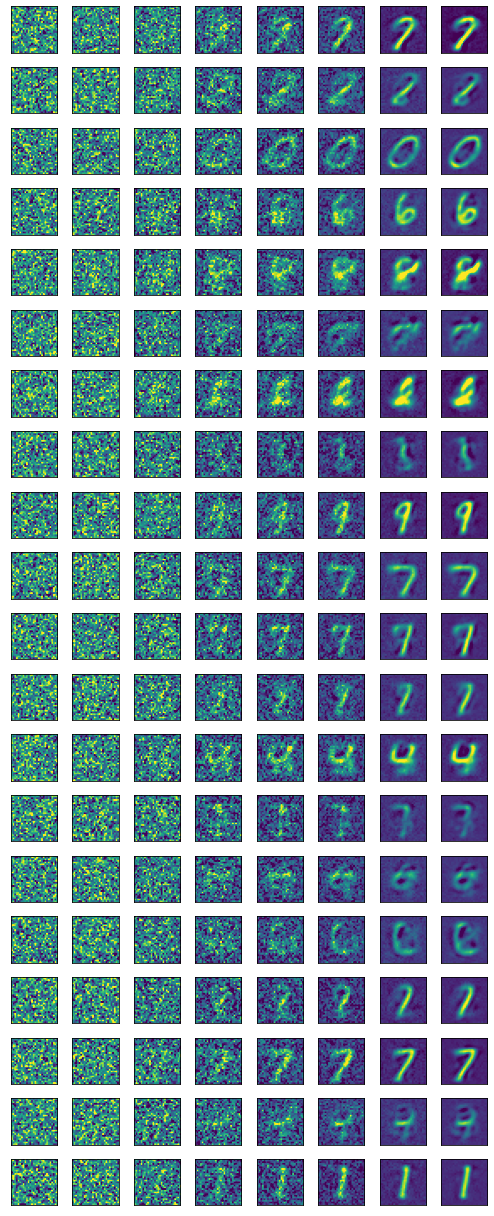

In [464]:
Ns = 20
Nsteps = 8
ats = [0,200,500,700,800,900,990,998]
XG = generate(trained_model,Nsteps*Ns,999, return_trajectory=True)
trajs = torch.stack(XG).reshape(999,Nsteps*Ns,28,28)
f = show(np.swapaxes(trajs[np.array(ats),:Ns,:,:],0,1).reshape(XG[0].shape[0],28,28),Ns,Nsteps)
f.set_size_inches(7,17)

In [471]:
total = 1000
one = total - 400
two = total-one
X = generate(trained_model,1,one)

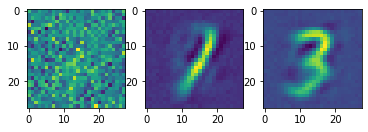

In [472]:
f,axarr = plt.subplots(1,3)
axarr[0].imshow(X.reshape(28,28))
XG = generate(trained_model,1,two, start = two, X = X)
axarr[1].imshow(XG.reshape(28,28))
XG = generate(trained_model,1,two, start = two, X = X)
axarr[2].imshow(XG.reshape(28,28))